random forest virus & bacteria species table 
IA or T1D
GROUP THE TRAIN/TEST SETS BY PATIENT

In [10]:
### load packages
import os
import os.path as path
import sys, os
import pandas as pd
import numpy as np
import math
import scipy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import re
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import random 

In [11]:
### location of this .ipynb
pathname =os.path.abspath("")
print (pathname)

### files
vir_table="../../intermediate_files/TGVG1.1_MPA4_combined_abundance.virus_species.wide.tsv"
bac_table="../../intermediate_files/TGVG1.1_MPA4_combined_abundance.bacteria_species.wide.tsv"
metadata_table="../../data/some_teddy_MP142_metadata2.all_samples1.delivery.csv"
ncc_table="../../data/MP142_CASE_CNTRL_T1D_LIST1.csv"

/Users/u241374/mike_tisza/cmmr_repos/teddy_vir_bac_marker_gene/scripts/5_host_population_comparisons


In [12]:
### parse OTU files down to 1% prevalence, the combine

vir_df = pd.read_csv(pathname + "/" + vir_table, sep="\t", header=0, index_col=0)

thresh = math.ceil(len(vir_df.columns)/100)

persist_vir_df = vir_df[vir_df[vir_df > float(0.0)].count(axis=1) >= thresh]

bac_df = pd.read_csv(pathname + "/" + bac_table, sep="\t", header=0, index_col=0)

thresh = math.ceil(len(bac_df.columns)/100)

persist_bac_df = bac_df[bac_df[bac_df > float(0.0)].count(axis=1) >= thresh]

persist_comb_df = pd.concat([persist_vir_df, persist_bac_df])


persist_comb_df = persist_comb_df.T

del vir_df
del bac_df

In [13]:
metadata_df = pd.read_csv(pathname + "/" + metadata_table, header=0, index_col=False)
metadata_df.index = metadata_df.index.map(int)
metadata_df['brst_fed'] = metadata_df['brst_fed'].fillna(0)
metadata_df['sample'] = metadata_df['sample'].astype(str)

ncc_df = pd.read_csv(pathname + "/" + ncc_table, header=0, index_col=False)

met_ncc = pd.merge(metadata_df, ncc_df, on = "mask_id", how = "left")

T1D = []
Country = []
IA = []
brst_fd = []
masks = []
is_NCC = []
for ind in persist_comb_df.index:
    state = met_ncc.loc[met_ncc['sample'] == ind, 'T1D'].values[0]
    country_q = met_ncc.loc[met_ncc['sample'] == ind, 'country'].values[0]
    ia1 = met_ncc.loc[met_ncc['sample'] == ind, 'IA'].values[0]
    milk = met_ncc.loc[met_ncc['sample'] == ind, 'brst_fed'].values[0]
    mid = met_ncc.loc[met_ncc['sample'] == ind, 'mask_id'].values[0]
    ncc = met_ncc.loc[met_ncc['sample'] == ind, 'outcome'].values[0]
    if milk == "":
        milk = 0
    brst_fd += [milk]
    Country += [country_q]
    T1D += [str(state)]
    IA += [str(ia1)]
    masks += [str(mid)]
    is_NCC += [ncc]
#random.shuffle(T1D)
c_df = pd.DataFrame({'country': Country, 'T1D': T1D, 'IA': IA, 'breast_fed': brst_fd, 'mask_id': masks, 'isnested': is_NCC}, index=persist_comb_df.index)
### map({1: "USA", 2: "Finland", 3: "Germany", 4: "Sweden"})
c_df['country'] = c_df['country'].map({1: "USA", 2: "other", 3: "other", 4: "other"})

country_df = pd.concat([persist_comb_df, c_df], axis=1)

country_ncc_df = country_df.query("isnested == isnested")

country_clean_df = country_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id', 'isnested'], axis=1)

In [14]:
### choose one of the phenotypes to test
discrim_var = "T1D"
#discrim_var = "IA"
number_models = 50

mask_id_list = country_ncc_df['mask_id'].tolist()
unique_mask_list = []

for x in mask_id_list:
    # check if exists in unique_list or not
    if x not in unique_mask_list:
        unique_mask_list.append(x)

perc70 = math.ceil(len(unique_mask_list)*0.7)

train_mask_list = random.sample(unique_mask_list, perc70)

test_mask_list = list(set(unique_mask_list) - set(train_mask_list))

train_sample_df = country_ncc_df.loc[country_ncc_df['mask_id'].isin(train_mask_list)]
train_sample_clean_df = train_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id', 'isnested'], axis=1)
train_sample_list = list(train_sample_df[discrim_var])

test_sample_df = country_ncc_df.loc[country_ncc_df['mask_id'].isin(test_mask_list)]
test_sample_clean_df = test_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id', 'isnested'], axis=1)
test_sample_list = list(test_sample_df[discrim_var])

[0.49535111186713265, 0.5173464222439166, 0.48879526585408933, 0.43900624451165965, 0.5270148286641343, 0.46074573665082474, 0.4754837122027746, 0.4059417665087768, 0.4681857891671519, 0.48610119047619044, 0.5144507507144869, 0.4305786940626591, 0.46371440301571304, 0.4442625404606433, 0.5073830441307166, 0.4181445967160252, 0.44148806281345676, 0.4966100104397603, 0.47767615176151756, 0.4412247778630622, 0.46885598048283533, 0.39819610953770146, 0.5079401552287581, 0.5043661674752162, 0.5159771920432774, 0.5095380667236955, 0.5014637156059651, 0.44316091954022996, 0.5769694119908292, 0.4779762741929466, 0.4354969870097375, 0.44233225195602077, 0.41223519049952173, 0.5098023916183203, 0.5395477401291355, 0.5060337905654065, 0.48658862632558353, 0.4560607007782952, 0.46312242915314494, 0.4352089538126979, 0.5028210439231217, 0.44190414620935475, 0.45558846579384105, 0.5101422881594337, 0.4832695559312984, 0.4033149853569034, 0.49786291396094506, 0.4389297658862876, 0.4849672146776551, 0

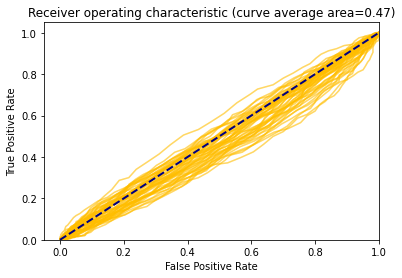

In [15]:
X=country_clean_df
y=list(country_ncc_df[discrim_var])

mask_id_list = country_ncc_df['mask_id'].tolist()
unique_mask_list = []

for x in mask_id_list:
    # check if exists in unique_list or not
    if x not in unique_mask_list:
        unique_mask_list.append(x)

perc70 = math.ceil(len(unique_mask_list)*0.7)

plt.figure()
ax = plt.gca()

#y = label_binarize(y, classes=[0, 1])
#print (X)

boot=range(int(number_models))
roc_series=[]
col = 0
import_df = pd.DataFrame(index = persist_comb_df.columns)
for q in boot:
	col += 1
	coln = "boot" + str(col)
	train_mask_list = random.sample(unique_mask_list, perc70)

	test_mask_list = list(set(unique_mask_list) - set(train_mask_list))

	train_sample_df = country_ncc_df.loc[country_ncc_df['mask_id'].isin(train_mask_list)]
	X_train = train_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id', 'isnested'], axis=1)
	y_train = list(train_sample_df[discrim_var])

	test_sample_df = country_ncc_df.loc[country_ncc_df['mask_id'].isin(test_mask_list)]
	X_test = test_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id', 'isnested'], axis=1)
	y_test = list(test_sample_df[discrim_var])
	random_state = np.random.RandomState(0)

	classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
	classifier.fit(X_train, y_train)
	#rfc_disp = plot_roc_curve(classifier, X_test, y_test, ax=ax, alpha=0.5, color='gold')
	rfc_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.5, color='gold')

	rfc_disp.plot(ax=ax, alpha=0.2, color='darkorange')
	#roc_auc = auc(classifier)
	y_pred_proba = classifier.predict_proba(X_test)
	try:
		roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
	except ValueError:
		pass

	feature_imp = pd.Series(classifier.feature_importances_,index=persist_comb_df.columns, name=str(coln))
	feature_imp = feature_imp.to_frame()

	import_df = import_df.join(feature_imp)

	lw = 2
	roc_series += [roc_auc]

print (roc_series)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
ax.get_legend().remove()
roc_avg=np.average(roc_series)
#plt.legend(['ROC curve (area = %0.2f)' % roc_avg])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (curve average area=%0.2f)' % roc_avg)
plt.show()

In [16]:
ind_dir = pathname + "/" + "../../intermediate_files/random_forest_outputs/"

if os.path.isdir(ind_dir):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(ind_dir)

import_df["avg_importance"] = import_df.mean(axis = 1)

import_df = import_df.sort_values(by=['avg_importance'], ascending=False)

import_df["avg_importance"].to_csv(str(ind_dir) + "/rf_important_all_sp_" + str(discrim_var) + "_vs_not1_NCC_groups.tsv", sep = "\t")

Exists


In [17]:
roc_df = pd.DataFrame({"Kingdom": "All", "Feature_type": "Disease", "Variable" :str(discrim_var), "AUC": roc_series})


roc_df.to_csv(str(ind_dir) + "rf_ROC_AUC_all_sp_" + str(discrim_var) + "_vs_not1_NCC_groups.tsv", sep = "\t", index = False)

In [18]:
os.system('say "your program has finished"')

0